In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from json import load
import tifffile
from tqdm import tqdm
from skimage.draw import polygon
from matplotlib import rcParams

palette = {
    "green": "#558150",
    "beige": "#F1E2C3",
    "brown": "#A7785A",
    "pink": "#F0D6C2",
    "black": "#0E0E0E",
}

rcParams['font.family'] = 'sans-serif'
rcParams['figure.facecolor'] = "#FFFFFF00"
rcParams['axes.facecolor'] = "#FFFFFF00"
rcParams['legend.framealpha'] = 0.2
rcParams['axes.edgecolor'] = palette["black"]
rcParams['axes.labelcolor'] = palette["black"]
rcParams['xtick.color'] = palette["black"]
rcParams['ytick.color'] = palette["black"]
rcParams['text.color'] = palette["black"]
rcParams['axes.titlecolor'] = palette["black"]

s_palette = sns.cubehelix_palette(as_cmap=True)

In [3]:
from src.utils.tracklets import import_tracklets

roots = ["embryo007", "embryo008", "embryo014a", "embryo016", "embryo018"]
datapath = Path().cwd().parent / "data" / "interim" / "confocal"
plotpath = datapath / "plots"
plotpath.mkdir(exist_ok=True)

spots, tracklets, metadatas, tracklets_joined = import_tracklets(datapath, roots)


In [14]:
print(tracklets_joined.columns)
print(spots[roots[0]].columns)

Index(['start_time', 'end_time', 'start_frame', 'end_frame', 'length',
       'source_spot', 'sink_spot', 'mean_ap_position', 'source_ap_position',
       'sink_ap_position', 'initial_x', 'initial_y', 'final_x', 'final_y',
       'track_id', 'mean_edge_distance', 'track_n_tracklets', 'cycle',
       'embryo', 'tracklet_id', 'parent_tracklet', 'n_children',
       'e_parent_id'],
      dtype='object')
Index(['Unnamed: 0', 'ID', 'track_id', 'tracklet_id', 'distance_from_edge',
       'parent_id', 'daughter_id', 'roi', 'FRAME', 'POSITION_X', 'POSITION_Y',
       'POSITION_Z', 'ELLIPSE_MAJOR', 'ELLIPSE_MINOR', 'ELLIPSE_THETA',
       'ELLIPSE_Y0', 'ELLIPSE_X0', 'ELLIPSE_ASPECTRATIO', 'CIRCULARITY',
       'AREA', 'SHAPE_INDEX', 'MEDIAN_INTENSITY_CH1', 'time', 'um_from_edge',
       'um_x', 'um_y', 'ap_position', 'edge_position', 'track_n_tracklets',
       'cycle'],
      dtype='object')


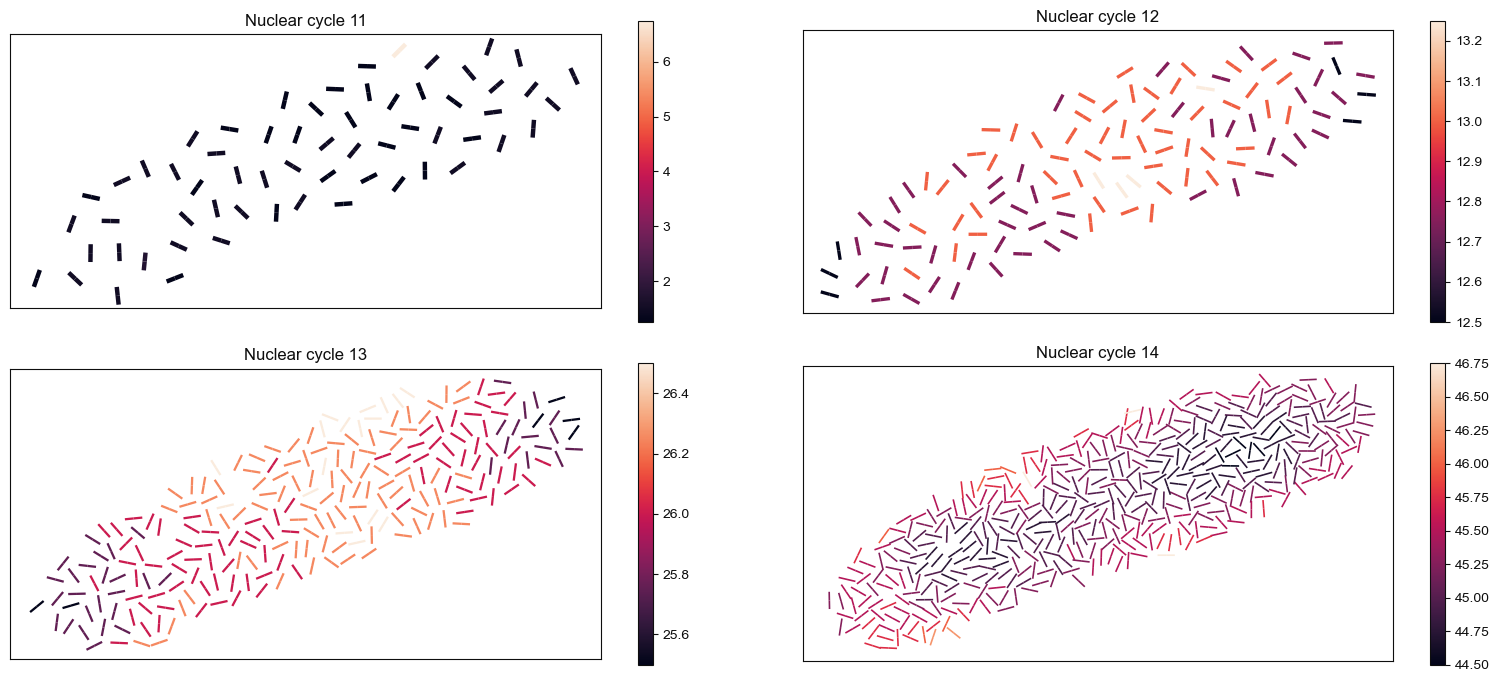

In [82]:
root = "embryo007"
fig, axes = plt.subplots(2, 2, figsize=(16, 7))
plt.tight_layout()
for cycle, ax in zip(range(11, 15), axes.flatten()):
    r_tracklets = tracklets[root]
    this_tracklets = r_tracklets[r_tracklets["cycle"] == cycle]
    
    source_pos = {tracklet: [] for tracklet in this_tracklets[~this_tracklets["parent_tracklet"].isin([-1, 0])]["parent_tracklet"]}
    
    x, y = this_tracklets.initial_x, this_tracklets.initial_y
    for parent, this_x, this_y in zip(this_tracklets["parent_tracklet"], x, y):
        if (parent == -1) or (parent == 0):
            continue
        source_pos[parent].append((this_x, this_y))
        
    source_pos = {tracklet: pos for tracklet, pos in source_pos.items() if len(pos) == 2}
            
    prev_tracklets = r_tracklets[r_tracklets["cycle"] == cycle - 1]
    prev_tracklets = prev_tracklets[prev_tracklets["tracklet_id"].isin(source_pos.keys())]
        
    missing = [tracklet for tracklet in source_pos.keys() if tracklet not in prev_tracklets["tracklet_id"]]
    source_pos = {tracklet: pos for tracklet, pos in source_pos.items() if tracklet not in missing}
    
    x = [prev_tracklets.loc[tracklet, "final_x"] for tracklet in source_pos.keys()]
    y = [prev_tracklets.loc[tracklet, "final_y"] for tracklet in source_pos.keys()]
    c = [prev_tracklets.loc[tracklet, "end_time"] for tracklet in source_pos.keys()]
    
    div_angle = lambda pt1, pt2: np.arctan2(pt2[1] - pt1[1], pt2[0] - pt1[0])
    angles = [div_angle(pts[0], pts[1]) for pts in source_pos.values()]
    u = np.cos(angles)
    v = np.sin(angles)
    
    x_y_rat = (np.max(x) - np.min(x)) / (np.max(y) - np.min(y))
    
    ax.quiver(x, y, u*20, v*20, c, angles='xy', scale_units='xy', scale=1, color=palette["black"], headwidth=0, headlength=0, headaxislength=0)
    bar = ax.quiver(x, y, -u*20, -v*20, c, angles='xy', scale_units='xy', scale=1, color=palette["black"], headwidth=0, headlength=0, headaxislength=0)
    ax.set_aspect("equal")
    ax.set_title(f"Nuclear cycle {cycle}")
    ax.set_xticks([])
    ax.set_yticks([])
    plt.colorbar(bar)
plt.savefig(plotpath / f"{root} division_angles.png", dpi=150)
plt.show()


In [4]:
def cousin_distance(tracklet_parents, a, b):
    a_lin, b_lin = [a], [b]
    while a_lin[-1] != -1:
        a_lin.append(tracklet_parents[a_lin[-1]])
    while b_lin[-1] != -1:
        b_lin.append(tracklet_parents[b_lin[-1]])
    for i, a in enumerate(a_lin):
        for j, b in enumerate(b_lin):
            if a == b:
                if a == -1:
                    return 0, 0
                return min(i, j), abs(i - j)

In [25]:
from scipy.spatial import Voronoi
from math import floor
import networkx as nx

graphs = {}
neighbors_all, graph_distances_all, graph_max_all = [], [], []
counts_all = []
# con_counts_all = []

for root in roots:
    graphs[root] = []
    for frame in tqdm(range(int(spots[root]["FRAME"].max()))):
        graph = nx.Graph()
        
        embryo_points = spots[root]
        embryo_points = embryo_points[embryo_points["FRAME"] == frame]

        pts = embryo_points[["um_x", "um_y"]].values
        tracklet_ids = embryo_points["tracklet_id"].values

        vor = Voronoi(pts)

        for a, b in vor.ridge_points:
            graph.add_edge(tracklet_ids[a], tracklet_ids[b])
            
        graphs[root].append(graph)
        
    this_tracklets = tracklets[root]
    
    track_counts = this_tracklets["track_id"].value_counts()
    best_tracks = track_counts[track_counts == 31].index
    
    track_tracklets = {key: [] for key in best_tracks}
    best_tracklets = this_tracklets[this_tracklets["track_id"].isin(best_tracks)]
    for tracklet in best_tracklets.index:
        track_tracklets[best_tracklets.loc[tracklet, "track_id"]].append(tracklet)
        
    this_tracklets["parent_tracklet"].fillna(0, inplace=True)
        
    tracklet_parents = {tracklet: parent for tracklet, parent in zip(this_tracklets["tracklet_id"], this_tracklets["parent_tracklet"])}
    
    neighbors = np.zeros((5, 5))
    graph_distances = np.zeros((5, 5))
    graph_max = np.zeros((5, 5))
    counts = [[[] for _ in range(5)] for _ in range(5)]
    # con_counts = [[[] for _ in range(5)] for _ in range(5)]
    
    for track in tqdm(best_tracks):
        for frame in range(len(graphs[root])):
            subgraph = graphs[root][frame].subgraph(track_tracklets[track])
            nodes = list(subgraph.nodes)

            for i, a in enumerate(nodes):
                for j, b in enumerate(nodes):
                    if i >= j:
                        continue
                    dist, diff = cousin_distance(tracklet_parents, a, b)
                    if dist > 4 or diff > 4:
                        print("warn")
                    else:
                        neighbors[dist, diff] += 1
                        g_dis = nx.shortest_path_length(graphs[root][frame], a, b)
                        # xa, ya = this_tracklets.loc[a, "final_x"], this_tracklets.loc[a, "final_y"]
                        # xb, yb = this_tracklets.loc[b, "final_x"], this_tracklets.loc[b, "final_y"]
                        # d_dis = np.linalg.norm([xa - xb, ya - yb])
                        graph_distances[dist, diff] += g_dis
                        graph_max[dist, diff] = max(graph_max[dist, diff], g_dis)
                        counts[dist][diff].append(g_dis)
                        # con_counts[dist][diff].append(d_dis)
    neighbors_all.append(neighbors)
    graph_distances_all.append(graph_distances)
    graph_max_all.append(graph_max)
    counts_all.append(counts)
    # con_counts_all.append(con_counts)


100%|██████████| 58/58 [00:13<00:00,  4.33it/s]


In [26]:
np.sum(neighbors_all)

1459970.0

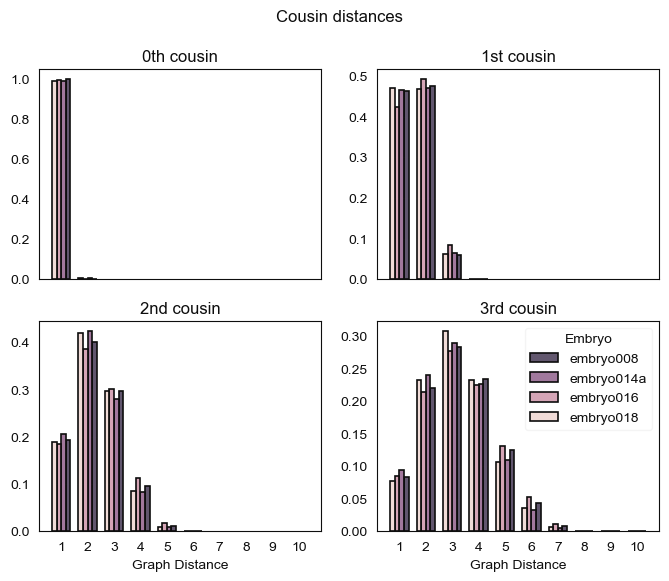

In [6]:
c = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex=True)
for j, ax in enumerate(axes.flatten()):
    labels = [i for i, _ in enumerate(roots) for _ in counts_all[i][j + 1][0]]
    vals = [val for i, _ in enumerate(roots) for val in counts_all[i][j + 1][0]]
    df = pd.DataFrame({"vals": vals, "labels": labels})
    sns.histplot(df, x="vals", hue="labels", discrete=True, ax=ax,  stat="density", multiple="dodge", shrink=0.7, common_norm=False, legend=False, edgecolor=palette["black"], linewidth=1.2)
    ax.set_xlabel("Graph Distance")
    ax.set_xticks(range(1, 11))
    ax.set_ylabel("")
    ax.set_title(f'{["0th", "1st", "2nd", "3rd"][j]} cousin')
fig.suptitle(f"Cousin distances")
plt.legend(title="Embryo", labels=roots)
plt.savefig(plotpath / "cousin_distances.png", dpi=150) 
plt.show()

-3.177312053403077
-3.1708036856095414
-3.176723834354081
-3.1694575710956245
1.014278142251314
1.118968675299022
1.0253618540330358
1.0234485039829782
1.9929491215028456
2.102681370063057
1.9406610548789685
2.0280914311369056
3.044241070188224
3.1772925565544443
2.978314819330277
3.1173007840809195


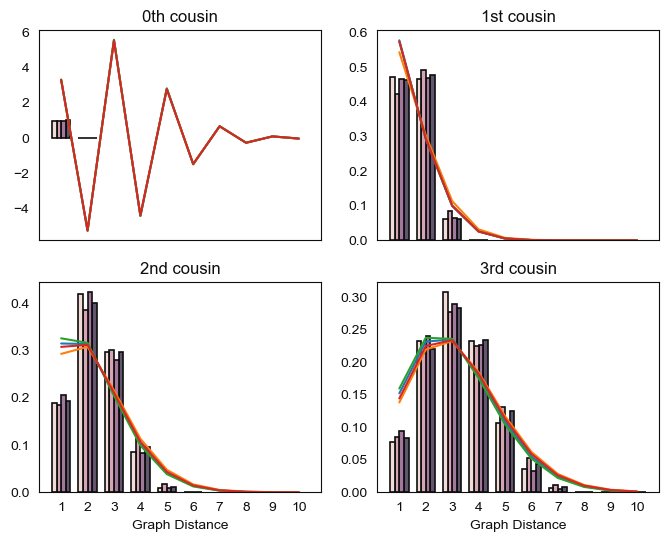

In [30]:
import math

def estimate_lambda(x):
    mean = np.mean(x)
    
    # solve lam / (1 - exp(-lam)) = mean
    lam = 1
    for _ in range(100):
        lam = lam - (lam / (1 - np.exp(-lam)) - mean) / (1 - np.exp(-lam) + lam * np.exp(-lam))

    return lam

# model zero truncated poisson
def zero_truncated_poisson(lam, k):
    return lam**k / ((np.exp(lam) - 1) * math.factorial(k))

fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex=True)
for j, ax in enumerate(axes.flatten()):
    labels = [i for i, _ in enumerate(roots) for _ in counts_all[i][j + 1][0]]
    vals = [val for i, _ in enumerate(roots) for val in counts_all[i][j + 1][0]]
    df = pd.DataFrame({"vals": vals, "labels": labels})
    sns.histplot(df, x="vals", hue="labels", discrete=True, ax=ax,  stat="density", multiple="dodge", shrink=0.7, common_norm=False, legend=False, edgecolor=palette["black"], linewidth=1.2)
    ax.set_xlabel("Graph Distance")
    ax.set_xticks(range(1, 11))
    ax.set_ylabel("")
    ax.set_title(f'{["0th", "1st", "2nd", "3rd"][j]} cousin')
    
    for i, root in enumerate(roots):
        lam = estimate_lambda(np.mean(counts_all[i][j + 1][0]))
        print(lam)
        x = np.arange(1, 11)
        y = [zero_truncated_poisson(lam, k) for k in x]
        ax.plot(x, y, color=c[i], label=root)


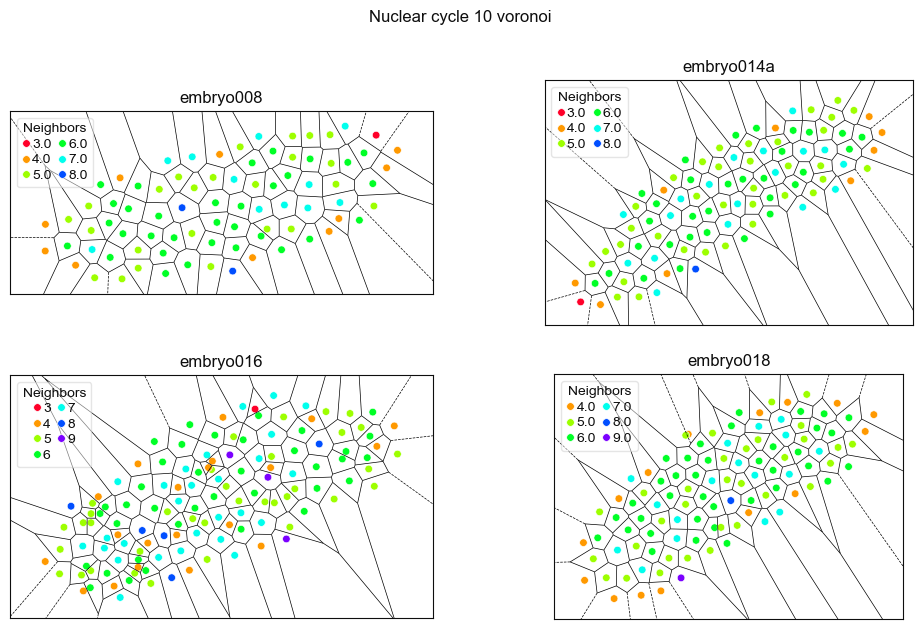

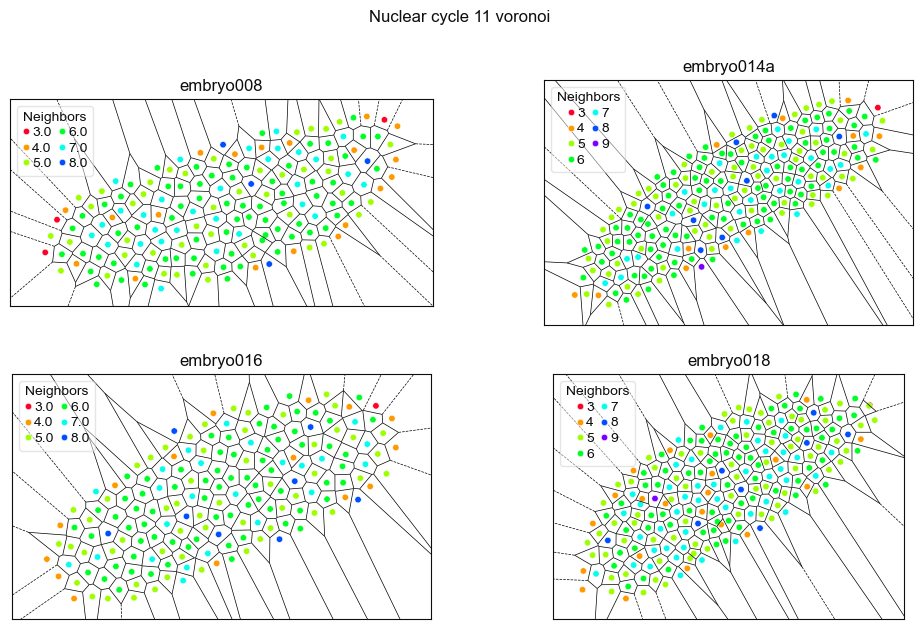

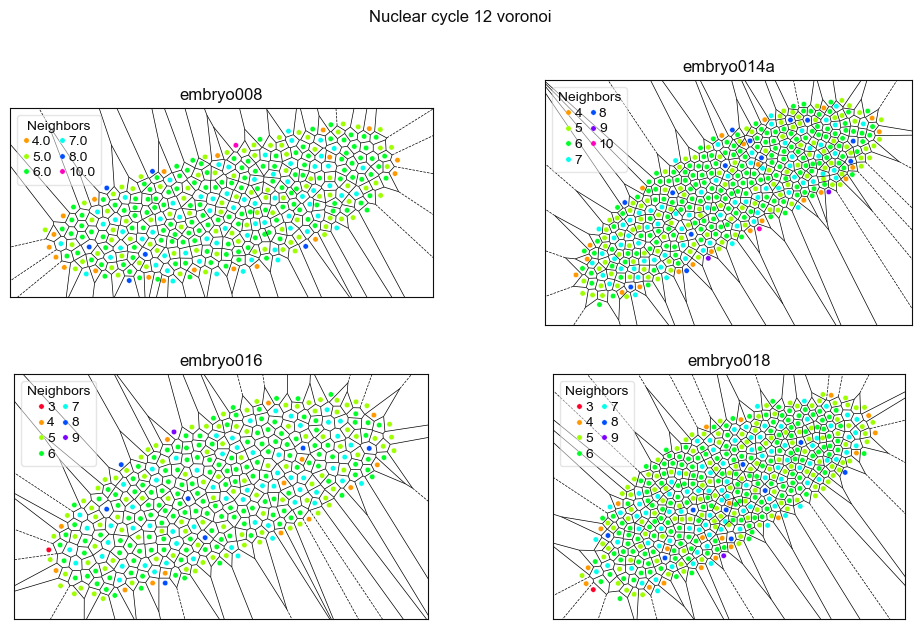

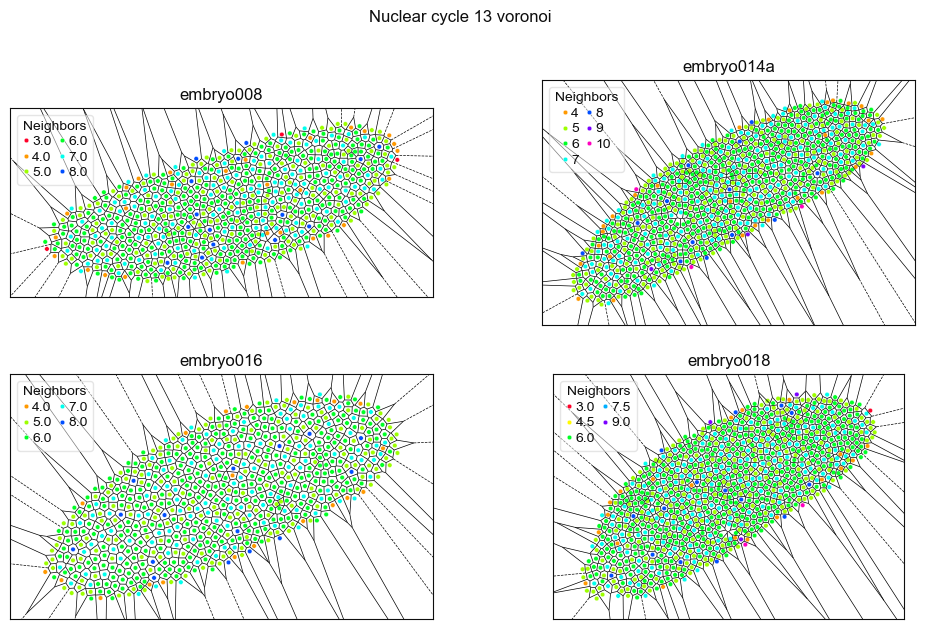

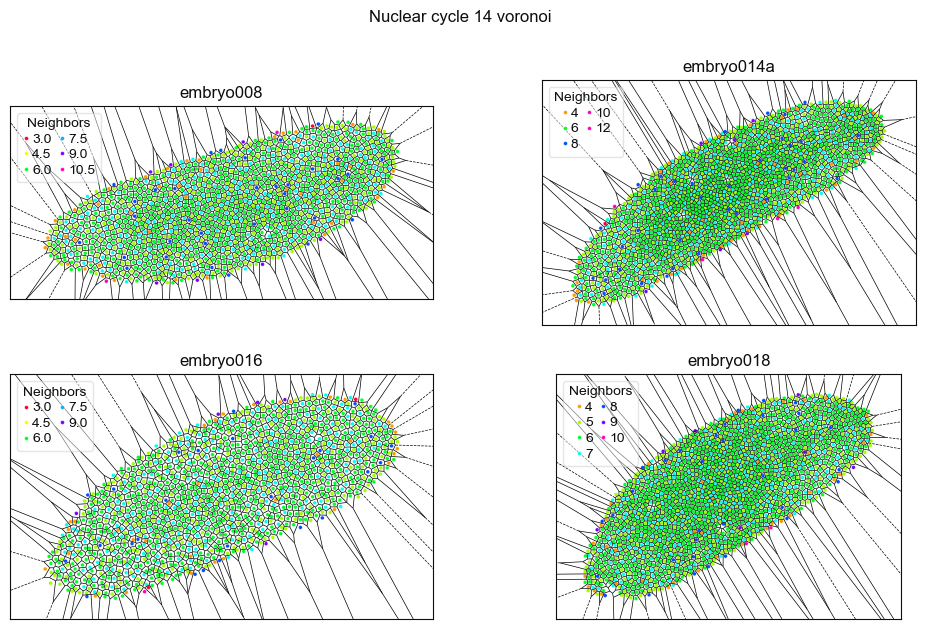

In [17]:
from scipy.spatial import Voronoi, voronoi_plot_2d
from math import floor

for nc in range(5):
    fig, axes = plt.subplots(2, 2, figsize=(12, 7))
    
    for root, ax in zip(roots, axes.flatten()):
        peaks = metadatas[root]["division_times"]
        interphase_dividers = [(p1 + p2) / 2 for p1, p2 in zip(peaks, peaks[1:])]
        interphase_dividers.append((tracklets[root]["end_frame"].max() + peaks[-1]) / 2)
        
        embryo_points = spots[root]
        embryo_points = embryo_points[embryo_points["FRAME"] == floor(interphase_dividers[nc])]

        vor = Voronoi(embryo_points[["um_x", "um_y"]])
        
        n_neighbors = np.zeros(len(embryo_points))
        for a, b in vor.ridge_points:
            if a == -1 or b == -1:
                continue
            n_neighbors[a] += 1
            n_neighbors[b] += 1
        voronoi_plot_2d(vor, ax=ax, show_vertices=False, show_points=False, line_width=0.5)
        norm = plt.Normalize(vmin=3, vmax=10)
        s = 30 / 2**(nc / 2)
        ax.set_aspect("equal")
        sns.scatterplot(x=embryo_points["um_x"],y=embryo_points["um_y"], hue=n_neighbors, ax=ax, palette="gist_rainbow", hue_norm=norm, s=s)
        ax.legend(title="Neighbors", loc="upper left", ncols=2, labelspacing=0.2, columnspacing=0.5, handletextpad=0.2, handlelength=0.5, framealpha=0.5)
        ax.set_title(root)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylabel("")
        ax.set_xlabel("")
    fig.suptitle(f"Nuclear cycle {nc + 10} voronoi")
    plt.savefig(plotpath / f"voronoi_nc{nc + 10}.png", dpi=150)
    plt.show()